<a href="https://colab.research.google.com/github/krislars/GaiaExtinctionTutorial/blob/main/GaiaExtinctionTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating Extinction in the Gaia Filters: A Tutorial

Kristen Larson (Western Washington University) larsonk@wwu.edu

I welcome contributors at https://github.com/krislars/GaiaExtinctionTutorial

If you find this work helpful in published work, I would appreciate a note or acknowledgement.  Thank you!


## Introduction

Extinction corrections in the Gaia filters depend on the background source spectrum and the spectral extinction curve ([Jordi et al 2010](https://ui.adsabs.harvard.edu/abs/2010A%26A...523A..48J/abstract), [Danielski et al 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...614A..19D/abstract), [Gaia website](https://www.cosmos.esa.int/web/gaia/edr3-extinction-law)).  To understand why, start with the definition of magnitude extinction,
$$
A_{\rm band} = -2.5 \log_{10} \left( \frac{\int F_{*\lambda}e^{-\tau_\lambda}W_\lambda d\lambda}{\int F_{*\lambda}W_\lambda d\lambda} \right)
$$
where $F_{*\lambda}$ is the background source flux, $W_\lambda$ is the filter transmission, and $\tau_\lambda$ is the optical depth. Instead of optical depth, astronomers often use a spectral extinction curve $A_\lambda$, where
$$
e^{-\tau_\lambda} = 10^{-0.4 A_\lambda} 
$$

If the background source flux and extinction curve are nearly constant in the filter bandpass, then the integral simplifies to $A_{\rm band} \simeq A_\lambda$.  In practice, this approximation can be made for narrow-band filters.  In the case of the extremely wide Gaia filters, this approximation is not valid.

In this tutorial, we show users how any source spectrum and extinction curve can be used to make customized, context-specific extinction corrections.  We also demonstrate some of the features of dust_extinction, an affiliated package of Astropy, to show how its wide array of available extinction curves can be accessed and easily used in synthetic photometry.




## Installs

In [1]:
!pip install speclite # provides access to filters

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install dust_extinction # provides access to a wide range of extinction curves

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install wget # to allow download of Kurucz stellar spectra from STScI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter
import speclite.filters
from dust_extinction.parameter_averages import F99,M14,G16,F19,F04,CCM89 # more available!
from astropy.modeling.models import BlackBody
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
import wget

## Get Filters

We use speclite to get the filter response curves and to perform the synthetic photometry.  Here are the Gaia filter response curves.

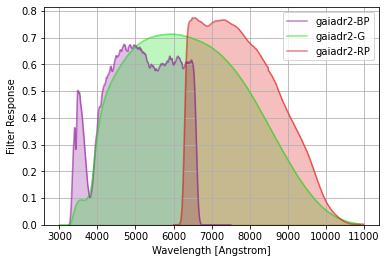

In [5]:
filters = speclite.filters.load_filters('gaiadr2-*') # replace with dr3 when available
speclite.filters.plot_filters(filters)

In [6]:
shortnames = [filters.names[0][-2:],filters.names[1][-1:],filters.names[2][-2:]]
shortnames

['BP', 'G', 'RP']

## Choose Extinction Curve

We use dust_extinction to access and make calculations with an extinction curve.  There are a [wide range of extinction curves](https://dust-extinction.readthedocs.io/en/latest/dust_extinction/model_flavors.html) to choose from, and dust_extinction makes it easy to test them in calculations.  Here we choose the extinction curve from Fitzpatrick (2019), but we encourage users to try other extinction curves, too.  A sample investigation of different curves will be posted with this tutorial.

In [7]:
ext = F19(Rv=3.1)

There are two main methods for using dust_extinction.  Calling the default ``ext(wavelengths)`` returns the spectral extinction curve, $A_\lambda / A_V$.  The method ``ext.extinction(wavelengths,Av=1)`` is also provided and returns $10^{-0.4 A_\lambda}$. 

## Choose Source Spectrum & Calculate Synthetic Photometry

Next, we choose a background source spectrum and calculate the photometry.  

Note that we use the method for ab magnitudes (uniform zero point) even though Gaia is on a Vega magnitude system.  Results will be the same because in calculating extinction, the zero point drops out. 

### Option 1: Constant Flux

Looking up the extinction curve for a single wavelength value and using that for magnitude extinction is equivalent to assuming a constant flux in the passband,

$$
A_{\rm band} = -2.5 \log_{10} \left( \frac{\int F_{*} 10^{-0.4 A_\lambda} W_\lambda d\lambda}{\int F_{*}W_\lambda d\lambda} \right) = -2.5 \log_{10} \left( \frac{\int 10^{-0.4 A_\lambda} W_\lambda d\lambda}{\int W_\lambda d\lambda} \right)
$$

Here we calculate extinction in the Gaia bands for $A_V = 1$ assuming a constant flux.  These values will be the nominal values we compare to in later calculations.

In [8]:
wavelengths = np.arange(2900,11000)*u.AA
spectrum = np.ones(len(wavelengths)) * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr)
spectrum_ext = spectrum*ext.extinguish(wavelengths, Av=1.0)
flux = spectrum * u.sr
flux_ext = spectrum_ext * u.sr
mags = filters.get_ab_magnitudes(flux, wavelengths)
mags_ext = filters.get_ab_magnitudes(flux_ext, wavelengths)
constflux_AV1 = np.zeros(3)
for i,f in enumerate(filters.names):
    constflux_AV1[i]=mags_ext[f]-mags[f]
    print('A_'+shortnames[i]+' = ',constflux_AV1[i])

A_BP =  1.0713588795294378
A_G =  0.7970388934886863
A_RP =  0.6297161497014976


### Option 2: Blackbody

The next easiest calculation to make is to assume a perfect blackbody spectrum, simple to do with Astropy models.

$$
A_{\rm band} = -2.5\log_{10} \left(\frac{\int B_{T,\lambda} 10^{-0.4 A_\lambda} W_\lambda d\lambda}{\int B_{T,\lambda}W_\lambda d\lambda} \right)
$$

We use the Table architecture of Astropy to keep track of the models at a range of temperatures and at a range of $A_V$ values.

In [9]:
bbtable = Table()
bbtable['temp'] = np.arange(3000,50000,1000)*u.K

AV = [0.5,1.0,1.5,2.0,2.5]

colors=['purple','green','red']

for av in AV:
    for f,fs in zip(filters.names,shortnames): # initialize columns
        bbtable[fs+'_AV'+ str(av)]=0.

    for i,temp in enumerate(bbtable['temp']):
        bb_lam = BlackBody(temp*u.K, scale=1.0 * 
                       u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
        spectrum = bb_lam(wavelengths)
        spectrum_ext = spectrum*ext.extinguish(wavelengths, Av=av)
        flux = spectrum * u.sr
        mags = filters.get_ab_magnitudes(flux, wavelengths)
        flux_ext = spectrum_ext * u.sr
        mags_ext = filters.get_ab_magnitudes(flux_ext, wavelengths)
    
        for f,fs in zip(filters.names,shortnames):
            bbtable[fs+'_AV'+ str(av)][i]=mags_ext[f]-mags[f]

Let's see what that table looks like.

In [10]:
bbtable

temp,BP_AV0.5,G_AV0.5,RP_AV0.5,BP_AV1.0,G_AV1.0,RP_AV1.0,BP_AV1.5,G_AV1.5,RP_AV1.5,BP_AV2.0,G_AV2.0,RP_AV2.0,BP_AV2.5,G_AV2.5,RP_AV2.5
K,,,,,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3000.0,0.4851187247593032,0.3530635233035113,0.3086649150833267,0.9655382997860755,0.6985061362256815,0.6144248694435746,1.4416696934328712,1.0369121746987346,0.917326332238467,1.9138897973111355,1.3688136309070416,1.2174213732721597,2.3825423558805667,1.694693205575085,1.5147670642300852
4000.0,0.5085124780298642,0.38720677900160183,0.31890925529605596,1.0102700328696486,0.7640007628507064,0.634797901961285,1.5058403863235128,1.1311860919366836,0.9476892638668488,1.995758206545453,1.4895176274800832,1.2576140121215786,2.480521661168247,1.839694912074762,1.5646097550453675
5000.0,0.5272258327383668,0.4132072782098817,0.3249885983320908,1.0461191111046801,0.8139578266870942,0.6469284160922868,1.5573298334994234,1.203143360365111,0.9658271433507011,2.0614885336092783,1.581636670375815,1.2817004263094844,2.559196918838083,1.9502726909094505,1.5945716359043303
6000.0,0.5419528335539994,0.4328689449916894,0.3289042731881793,1.0744112548513272,0.8518660737711272,0.654758074299032,1.598054728024323,1.2578851093914238,0.9775586249071324,2.1135624255667835,1.6518397154376032,1.297311287431242,2.621598260758745,2.034633669963654,1.6140294665865156
7000.0,0.5535518275995983,0.44786451056725696,0.33159018957899633,1.0967597126759046,0.8808825677491399,0.6601363386730128,1.6303015703013628,1.2999087446604136,0.9856284154642978,2.154874994207333,1.7058543457922184,1.3080645542560418,2.6711777879936847,2.0996501392090536,1.6274510528436466
8000.0,0.5627639277982723,0.4594779447883326,0.3335251923976159,1.1145577660829957,0.9034278180029105,0.6640148673185635,1.6560417477682066,1.3326495503494442,0.9914537694837193,2.1879142467616575,1.7480310827670635,1.3158347750648716,2.7108890015050164,2.150506589500317,1.6371589593110158
9000.0,0.5701652114332063,0.4686290365626391,0.33497457316702395,1.1288920711566348,0.9212425576928851,0.6669221796540299,1.6768158056906017,1.3585828924293537,0.9958236685784101,2.2146259481624995,1.7815059000858824,1.3216679650446537,2.7430412576914023,2.1909367417002414,1.6444521904967786
10000.0,0.5761867261241491,0.4759641359305533,0.33609489161422346,1.1405789390048682,0.9355558365785015,0.6691707168876846,1.6937843820355525,1.3794623751311335,0.9992053309128792,2.2364789133814753,1.8085051049539516,1.3261846044272403,2.769379882423607,2.2235941133321546,1.6501025847394715


Now we can plot extinction in the Gaia filters as a function of temperature of different values of $A_V$.

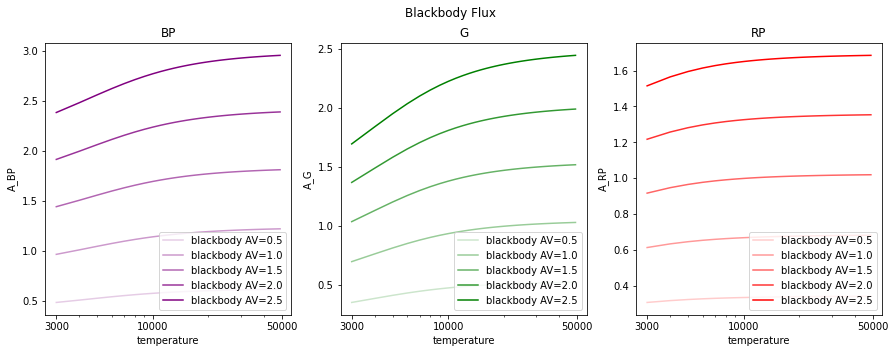

In [11]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

for i,fs in enumerate(shortnames):
    for av in AV:
        axs[i].plot(bbtable['temp'],bbtable[fs+'_AV'+str(av)],c=colors[i],
                    alpha=av/max(AV),label='blackbody AV='+str(av))
        axs[i].set_xscale('log')
        axs[i].xaxis.set_major_formatter(ScalarFormatter())
        axs[i].set_xticks([3000,10000,50000])
        axs[i].set_xlabel('temperature')
        axs[i].set_ylabel('A_'+fs)
        axs[i].set_title(fs)
        axs[i].legend(loc='lower right')
plt.suptitle('Blackbody Flux')
plt.show()

Each Gaia curve is simply a multiplying factor away from the $A_V=1$ Gaia curve curve.  What is more useful here is to normalize to $A_V$ and overplot the nominal value from the constant flux approximation.

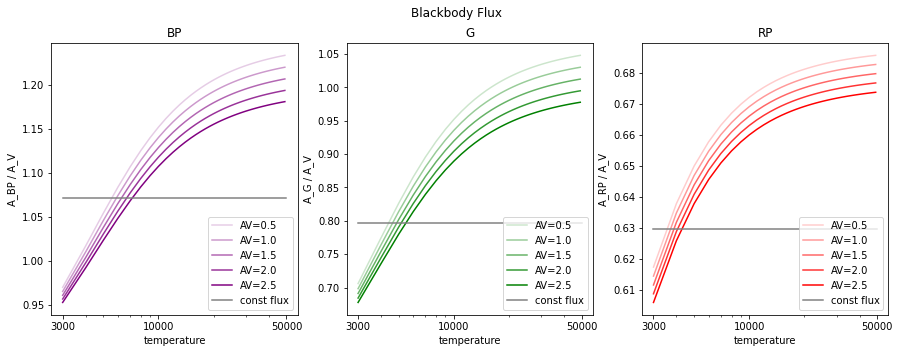

In [12]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

for i,fs in enumerate(shortnames):
    for av in AV:
        axs[i].plot(bbtable['temp'],bbtable[fs+'_AV'+str(av)]/av,c=colors[i],
                    alpha=av/max(AV),label='AV='+str(av))
    axs[i].set_xscale('log')
    axs[i].xaxis.set_major_formatter(ScalarFormatter())
    axs[i].set_xticks([3000,10000,50000])
    axs[i].set_xlabel('temperature')
    axs[i].set_ylabel('A_'+fs+' / A_V')
    axs[i].set_title(fs)
    axs[i].plot([3000,50000],[constflux_AV1[i],constflux_AV1[i]],
                color='grey',label='const flux')
    axs[i].legend(loc='lower right')
plt.suptitle('Blackbody Flux')
plt.show()

Notice that the normalized extinction depends both on the source temperature and the amount of foreground dust.  In other words, normalizing the extinction to $V$ does not remove the dependence on the total amount of dust.  Why?  Because extinction removes more short-wavelength than long-wavelength light, which when propagated through the filter response curve, is not a simple multiplying factor.

What might be more useful for observers is the effective wavelength for looking up with the ``ext(wavelength)`` method of dust_extinction .

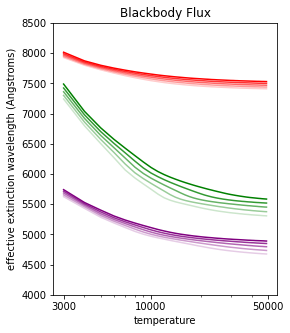

In [13]:
fig,ax = plt.subplots(1,1,figsize=(4,5))

colors=['purple','green','red']
for i,fs in enumerate(shortnames):
    for av in AV:
        bbtable[fs+'_l_eff_AV'+str(av)] = 0. # initialize column
        for j in range(len(bbtable['temp'])):
            # find the wavelength with the minimum difference between the 
            #   extinction curve and calculations to get effective wavelength 
            idx = [np.abs(av*ext(wavelengths) - bbtable[fs+'_AV'+str(av)][j]).argmin()]
            bbtable[fs+'_l_eff_AV'+str(av)][j] = wavelengths[idx].value
        plt.plot(bbtable['temp'],bbtable[fs+'_l_eff_AV'+str(av)],c=colors[i],alpha=av/max(AV))
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([3000,10000,50000])
ax.set_xlabel('temperature')
ax.set_ylim([4000,8500])
ax.set_ylabel('effective extinction wavelength (Angstroms)')
ax.set_title('Blackbody Flux')
fig.show()

Because it is the widest band, the effective extinction wavelength in $G$ has the biggest temperature dependence and most dependence on the amount of foreground dust.

### Option 3: Stellar Atmosphere Models

Repeat as above, but each row is for a model spectral type, not a blackbody temperature.

$$
A_{\rm band} = -2.5 \log_{10} \left( \frac{\int F_{*\lambda}10^{-0.4 A_\lambda}W_\lambda d\lambda}{\int F_{*\lambda}W_\lambda d\lambda} \right)
$$

Here we choose [Castelli & Kurucz stellar models from STScI](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs/castelli-and-kurucz-atlas).  Choose the background source model that is best for your application.

In [14]:
stardict = { # from the STScI page referenced above
    'O3V'     : 'ckp00_45000[g45]',
    'O4V'	  : 'ckp00_43000[g45]',
    'O5V'	  : 'ckp00_41000[g45]',
    # 'O5_5V'   :	'ckp00_40000[g40]', # yields NANs?
    'O6V'	  : 'ckp00_39000[g40]',
    'O6_5V'   :	'ckp00_38000[g40]',
    'O7V'	  : 'ckp00_37000[g40]',
    'O7_5V'   : 'ckp00_36000[g40]',
    'O8V'	  : 'ckp00_35000[g40]',
    'O8_5V'   : 'ckp00_34000[g40]',
    'O9V'	  : 'ckp00_33000[g40]',
    'O9_5V'   :	'ckp00_32000[g40]',
    'B0V'	  : 'ckp00_30000[g40]',
    'B1V'	  : 'ckp00_25000[g40]',
    'B3V'	  : 'ckp00_19000[g40]',
    'B5V'	  : 'ckp00_15000[g40]',
    'B8V'	  : 'ckp00_12000[g40]',
    'A0V'	  : 'ckp00_9500[g40]',
    'A1V'	  : 'ckp00_9250[g40]',
    'A5V'	  : 'ckp00_8250[g40]',
    'F0V'	  : 'ckp00_7250[g40]',
    'F2V'	  : 'ckp00_7000[g40]',
    'F5V'	  : 'ckp00_6500[g40]',
    'F8V'	  : 'ckp00_6250[g45]',
    'G0V'	  : 'ckp00_6000[g45]',
    'G5V'	  : 'ckp00_5750[g45]',
    'G8V'	  : 'ckp00_5500[g45]',
    'K0V'	  : 'ckp00_5250[g45]',
    'K2V'	  : 'ckp00_4750[g45]',
    'K4V'	  : 'ckp00_4500[g45]',
    'K5V'	  : 'ckp00_4250[g45]',
    'K7V'	  : 'ckp00_4000[g45]',
    'M0V'	  : 'ckp00_3750[g45]',
    'M2V'	  : 'ckp00_3500[g45]',
    'M5V'	  : 'ckp00_3500[g50]',
    'B0III'   : 'ckp00_29000[g35]',
    'B5III'   : 'ckp00_15000[g35]',
    'G0III'   : 'ckp00_5750[g30]',
    'G5III'   : 'ckp00_5250[g25]',
    'K0III'   : 'ckp00_4750[g20]',
    'K5III'   : 'ckp00_4000[g15]',
    'M0III'   : 'ckp00_3750[g15]',
    'O5I'	  : 'ckp00_40000[g45]',
    'O6I'	  : 'ckp00_39000[g40]',
    'O8I'	  : 'ckp00_34000[g40]',
    'B0I'	  : 'ckp00_26000[g30]',
    'B5I'	  : 'ckp00_14000[g25]',
    'A0I'	  : 'ckp00_9750[g20]',
    'A5I'	  : 'ckp00_8500[g20]',
    'F0I'	  : 'ckp00_7750[g20]',
    'F5I'	  : 'ckp00_7000[g15]',
    'G0I'	  : 'ckp00_5500[g15]',
    'G5I'	  : 'ckp00_4750[g10]',
    'K0I'	  : 'ckp00_4500[g10]',
    'K5I'	  : 'ckp00_3750[g05]',
    'M0I'	  : 'ckp00_3750[g00]',
    'M2I'	  : 'ckp00_3500[g00]'}

Download all the files recommended from STScI.

In [15]:
for file in list(stardict.values()):
    url = 'https://archive.stsci.edu/hlsps/reference-atlases/cdbs/grid/ck04models/ckp00/'+file[:-5]+'.fits'
    filename = wget.download(url)

Create an Astropy type with spectral type and temperature.

In [16]:
startable = Table()
startable['type'] = list(stardict.keys())

# Get temps out of filenames.  Very crude, but it works!
startable['temp'] = 0.
for i,type in enumerate(startable['type']):
    if stardict[startable['type'][i]][10]=='[':
        startable['temp'][i] = stardict[startable['type'][i]][6:10]
    else:
        startable['temp'][i] = stardict[startable['type'][i]][6:11]

For each extinction value, calculate magnitudes with and without dust and record the difference in a table column for each Gaia bandpass.

In [17]:
for av in AV:
    for f,fs in zip(filters.names,shortnames): # initialize columns
        startable[fs+'_AV'+ str(av)]=0.

    for i,type in enumerate(startable['type']):
        star = fits.open(stardict[type][:-5]+'.fits')
        wavedat = star[1].data['WAVELENGTH'] * u.AA
        fluxdat = star[1].data[stardict[type][-4:-1]] * u.erg / (u.cm ** 2 * u.AA * u.s) 
        wav = wavedat[(wavedat > 2900*u.AA) & (wavedat < 12000*u.AA)] # clipped for dust_ext
        flux = fluxdat[(wavedat > 2900*u.AA) & (wavedat < 12000*u.AA)] # clipped for dust_ext

        mags = filters.get_ab_magnitudes(flux, wav)
        flux_ext = flux*ext.extinguish(wav, Av=av) 
        mags_ext = filters.get_ab_magnitudes(flux_ext, wav)
    
        for f,fs in zip(filters.names,shortnames):
            startable[fs+'_AV'+ str(av)][i]=mags_ext[f]-mags[f]

Separate into luminosity classes.

In [18]:
ms = np.arange(0,34,1)
gs = np.arange(34,41,1)
sg = np.arange(41,56,1)

And plot!

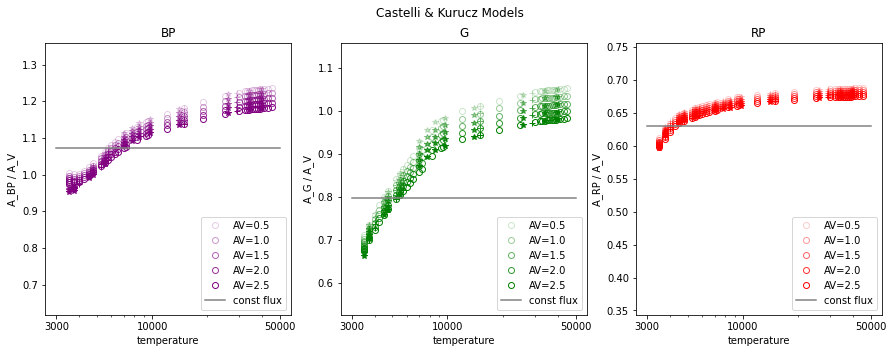

In [19]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

for i,fs in enumerate(shortnames):
    for av in AV:
        axs[i].plot(startable['temp'][ms],startable[fs+'_AV'+str(av)][ms]/av,
                    'o',c=colors[i],mfc='none',alpha=av/max(AV),
                    label='AV='+str(av))
        axs[i].plot(startable['temp'][gs],startable[fs+'_AV'+str(av)][gs]/av,
                    '+',c=colors[i],alpha=av/max(AV))
        axs[i].plot(startable['temp'][sg],startable[fs+'_AV'+str(av)][sg]/av,
                    '*',c=colors[i],alpha=av/max(AV))
    axs[i].plot([3000,50000],[constflux_AV1[i],constflux_AV1[i]],color='grey',
                label='const flux')
    axs[i].set_xlabel('temperature')
    axs[i].set_ylabel('A_'+fs+' / A_V')
    axs[i].set_xscale('log')
    axs[i].xaxis.set_major_formatter(ScalarFormatter())
    axs[i].set_xticks([3000,10000,50000])
    axs[i].set_title(fs)
    axs[i].legend(loc='lower right')

    ymax=np.max(startable[fs+'_AV0.5'][ms]/0.5)
    axs[i].set_ylim(ymax/2, 1.1*ymax)
plt.suptitle('Castelli & Kurucz Models')
plt.show()

We can show a normalized color excess, too.  (In $B$ and $V$ passbands, normalized color excess is known as inverse $R_V$.)

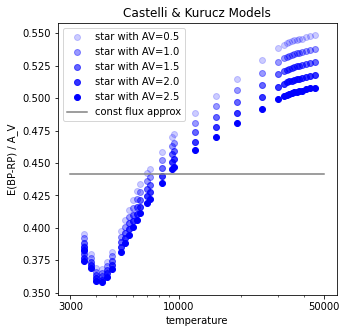

In [20]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
for av in AV:
    plt.plot(startable['temp'][ms],(startable['BP_AV'+str(av)][ms]/av - startable['RP_AV'+str(av)][ms]/av),
             'bo',alpha=av/max(AV),label='star with AV='+str(av))
ax.plot([3000,50000],[constflux_AV1[0]-constflux_AV1[2],constflux_AV1[0]-constflux_AV1[2]],
        color='grey',label='const flux approx')
ax.legend()
ax.set_xlabel('temperature')
ax.set_ylabel('E(BP-RP) / A_V')
ax.set_title('Castelli & Kurucz Models')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([3000,10000,50000])
plt.show()

What might be more useful for observers is the effective wavelength for looking up with dust_extinction.  The effective wavelength of a filter defined as the photon-weighted mean wavelength can be accessed directly through speclite and added to this plot as the reference value.

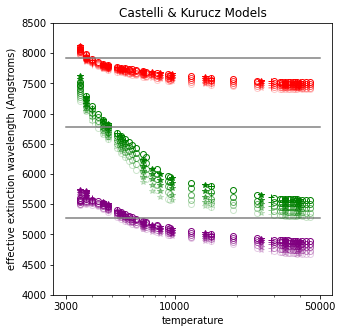

In [21]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

for i,fs in enumerate(shortnames):
    for av in AV:
        startable[fs+'_l_eff_AV'+str(av)] = 0. # initialize column
        for j in range(len(startable['type'])):
            # find the wavelength with the minimum difference between the 
            #   extinction curve and calculations to get effective wavelength
            idx = [np.abs(av*ext(wavelengths) - startable[fs+'_AV'+str(av)][j]).argmin()]
            startable[fs+'_l_eff_AV'+str(av)][j] = wavelengths[idx].value

        ax.plot(startable['temp'][ms],startable[fs+'_l_eff_AV'+str(av)][ms],
                'o',c=colors[i],mfc='none',alpha=av/max(AV))
        ax.plot(startable['temp'][gs],startable[fs+'_l_eff_AV'+str(av)][gs],
                '+',c=colors[i],alpha=av/max(AV))
        ax.plot(startable['temp'][sg],startable[fs+'_l_eff_AV'+str(av)][sg],
                '*',c=colors[i],alpha=av/max(AV))
    plt.plot([3000,50000],[filters.effective_wavelengths[i].value,filters.effective_wavelengths[i].value],color='grey')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.set_xticks([3000,10000,50000])
ax.set_ylim([4000,8500])
ax.set_xlabel('temperature')
ax.set_ylabel('effective extinction wavelength (Angstroms)')
ax.set_title('Castelli & Kurucz Models')
plt.show()

**Take Home Lesson:  Extinction in Gaia filters is not as simple as looking up a single effective wavelength for the filters in your favorite extinction curve.  The good news is that calculating it correctly is not too hard to do!**